In [8]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
pd.set_option('display.float_format', lambda x: '%.3g' % x if np.log10(x) > -1.5 else '%.1e' % x )
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

basepath = ""

def get_batchsize_list(N):
    s = 4
    ns = []
    for i in range(3, int(np.log2(N))+1):
        b = 2**i // s
        niters_per_layer = 8
        if i == 3: 
            niters_per_layer = 12
        elif i == int(np.log2(N)): 
            niters_per_layer = 10
        ns = ns + niters_per_layer*[b*b]
    return np.array(ns)

def ff(x):
    """
    format fraction
    """
    if x < 1:
        invx = 1/x
        if abs(invx - int(invx)) < 1e-8:
            invx = int(invx)
        return f"1/{invx}"
    else:
        if abs(x - int(x)) < 1e-8:
            x = int(x)
        return f"{x}"

In [9]:
# TODO: change names of domdec smart to just domdec
# TODO: clean mentions to other methods
import itertools
experiments_dir = "../examples/results/"
dict_results = dict()
Ns = [64, 128, 256, 512, 1024]
reaches = [0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]

methods = ["domdec", "sinkhorn"]
K = 10
pairs = [(i,j) for i in range(K) for j in range(i+1,K)]
efficiencies = []

for method in methods:
    for N, reach in itertools.product(Ns, reaches):
        for (i,j) in pairs:
            fname = experiments_dir + f'{method}-reach-{reach}-{N:0>4}-00{i}-00{j}.txt'
            try: 
                with open(fname, "r") as f:
                    dict_problem = json.loads(f.read())
                    dict_problem["pair_id"] = f"{i}{j}"
                    dict_problem["method"] = method
                    dict_problem["N"] = N
                    dict_problem["reach"] = reach
                    # Get final time
                    if method == "domdec":
                        # Problem time
                        global_time_list = [data[-1] for data in dict_problem["timeList_global"]]
                        dict_problem["time_total"] = global_time_list[-1]
                        # Problem sparsity
                        entries_list = [data[-1] for data in dict_problem["sparsity_muYAtomicEntries"]]
                        dict_problem["max_muYentries"] = max(entries_list)
                        dict_problem["final_muYentries"] = entries_list[-1]
                    
                        # Rename
                        dict_problem["time_iterate"] = dict_problem["time_sinkhorn"]
                        # Get bbox sizes
                        bbox_list = [data[-1] for data in dict_problem["shape_muYAtomicEntries"]]
                        #batchsize_list =  get_batchsize_list(N)
                        storage_efficiency = np.array(entries_list) / (np.array(bbox_list))
                        efficiencies.append(storage_efficiency)
                        dict_problem["worst_storage_ratio"] = np.min(storage_efficiency)
                        dict_problem["final_storage_ratio"] = storage_efficiency[-1]
                    if method == "sinkhorn":
                        dict_problem["time_total"] = dict_problem["time_iterate"] + dict_problem["time_refine"]
                        
                    dict_results[(method, N, reach, (i,j))] = dict_problem
                    
                    
            except FileNotFoundError:
                print(fname, "not found")
                dict_problem = dict()
                
                dict_problem["pair_id"] = f"{i}{j}"
                dict_problem["method"] = method
                dict_problem["N"] = N
                dict_problem["reach"] = reach
                dict_results[(method, N, reach, (i,j))] = dict_problem
            
                


In [10]:
# Load results to dataframe
new_keys = [
            "N", "reach", "method", "pair_id", "time_total", "time_sinkhorn",
            "time_iterate", "time_refine", "time_measureBalancing", 
            "time_PYpi", "time_warm_up",
            "time_measureTruncation", "time_bounding_box", "time_clustering",
            "solution_scoreDual", "solution_scorePrimal", 
            "solution_errorMargX", "solution_errorMargY",
            "max_muYentries", "final_muYentries", "worst_storage_ratio", "final_storage_ratio"
           ]
dict_results_df = dict()

for key in new_keys:
    list_results = []
    for (i, problem) in enumerate(dict_results.keys()):
        if key in dict_results[problem].keys():
            list_results.append(dict_results[problem][key])
        else:
            list_results.append(np.nan)
    dict_results_df[key] = list_results

df_microdata = pd.DataFrame.from_dict(dict_results_df)
# Add some new columns
df_microdata["solution_scoreGapRel"] = (df_microdata["solution_scorePrimal"] - df_microdata["solution_scoreDual"])/df_microdata["solution_scorePrimal"]   # Add new score to sinkhorn

df_microdata= df_microdata.sort_values(by = ["N", "reach"])
df_microdata.reset_index(inplace = True, drop = True)
df_microdata

/tmp/ipykernel_25077/2681610649.py:7: RuntimeWarning: divide by zero encountered in log10
  pd.set_option('display.float_format', lambda x: '%.3g' % x if np.log10(x) > -1.5 else '%.1e' % x )
/tmp/ipykernel_25077/2681610649.py:7: RuntimeWarning: divide by zero encountered in log10
  pd.set_option('display.float_format', lambda x: '%.3g' % x if np.log10(x) > -1.5 else '%.1e' % x )


,N,reach,method,pair_id,time_total,time_sinkhorn,time_iterate,time_refine,time_measureBalancing,time_PYpi,...,time_clustering,solution_scoreDual,solution_scorePrimal,solution_errorMargX,solution_errorMargY,max_muYentries,final_muYentries,worst_storage_ratio,final_storage_ratio,solution_scoreGapRel
0,64,3.1e-02,domdec,01,1.11,0.531,0.531,5.8e-03,0.0395,NaN,...,8.1e-04,2.51,2.52,1.8e-02,1.6e-02,5.23e+04,1.4e+04,0.625,0.857,2.4e-03
1,64,3.1e-02,domdec,02,1.11,0.532,0.532,5.9e-03,0.0393,NaN,...,8.5e-04,2.1,2.1,1.2e-02,1.1e-02,5.22e+04,1.4e+04,0.626,0.857,1.7e-03
2,64,3.1e-02,domdec,03,1.11,0.531,0.531,5.8e-03,0.0394,NaN,...,8.6e-04,2.46,2.47,1.8e-02,1.6e-02,5.23e+04,1.41e+04,0.624,0.861,2.6e-03
3,64,3.1e-02,domdec,04,1.11,0.537,0.537,5.9e-03,0.0396,NaN,...,8.4e-04,2.63,2.63,1.4e-02,1.2e-02,5.23e+04,1.41e+04,0.626,0.861,1.6e-03
4,64,3.1e-02,domdec,05,1.11,0.532,0.532,5.8e-03,0.0393,NaN,...,8.1e-04,2.34,2.34,1.3e-02,1.2e-02,5.24e+04,1.4e+04,0.628,0.855,1.8e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1024,16,sinkhorn,68,15,0.0e+00,14.9,1.9e-03,NaN,NaN,...,NaN,2.76e+03,8.12e+03,4.8e-03,2.3e-12,NaN,NaN,NaN,NaN,0.66
4496,1024,16,sinkhorn,69,18.3,0.0e+00,18.3,1.9e-03,NaN,NaN,...,NaN,9.79e+03,1.52e+04,4.9e-03,7.7e-12,NaN,NaN,NaN,NaN,0.354
4497,1024,16,sinkhorn,78,15.8,0.0e+00,15.8,3.6e-03,NaN,NaN,...,NaN,3.69e+03,9.06e+03,5.0e-03,3.1e-12,NaN,NaN,NaN,NaN,0.592
4498,1024,16,sinkhorn,79,16.8,0.0e+00,16.8,2.1e-03,NaN,NaN,...,NaN,3.45e+03,8.81e+03,5.0e-03,3.9e-12,NaN,NaN,NaN,NaN,0.609


In [11]:
# Compute aggreagted statistics
df_median = df_microdata.groupby(["N", "reach", "method"]).median().reset_index()
df_q0 = df_microdata.groupby(["N", "reach", "method"]).quantile(0.25).reset_index()
df_q1 = df_microdata.groupby(["N", "reach", "method"]).quantile(0.75).reset_index()

df_median

/tmp/ipykernel_25077/649122283.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_q0 = df_microdata.groupby(["N", "reach", "method"]).quantile(0.25).reset_index()
/tmp/ipykernel_25077/649122283.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_q1 = df_microdata.groupby(["N", "reach", "method"]).quantile(0.75).reset_index()
/tmp/ipykernel_25077/2681610649.py:7: RuntimeWarning: divide by zero encountered in log10
  pd.set_option('display.float_format', lambda x: '%.3g' % x if np.log10(x) > -1.5 else '%.1e' % x )
/tmp/ipykernel_25077/2681610649.py:7: RuntimeWarning: divide by zero encountered in log10
  pd.set_option('display.float_form

,N,reach,method,time_total,time_sinkhorn,time_iterate,time_refine,time_measureBalancing,time_PYpi,time_warm_up,...,time_clustering,solution_scoreDual,solution_scorePrimal,solution_errorMargX,solution_errorMargY,max_muYentries,final_muYentries,worst_storage_ratio,final_storage_ratio,solution_scoreGapRel
0,64,3.1e-02,domdec,1.1,0.531,0.531,5.8e-03,0.0394,NaN,NaN,...,8.1e-04,2.15,2.15,1.3e-02,1.1e-02,5.24e+04,1.4e+04,0.625,0.854,1.6e-03
1,64,3.1e-02,sinkhorn,0.125,0.0e+00,0.124,9.5e-04,NaN,NaN,NaN,...,NaN,2.15,2.15,3.8e-03,4.7e-16,NaN,NaN,NaN,NaN,1.8e-05
2,64,0.0625,domdec,1.55,0.958,0.958,5.8e-03,0.0409,NaN,NaN,...,8.1e-04,3.83,3.84,1.8e-02,1.6e-02,5.34e+04,1.4e+04,0.633,0.676,2.0e-03
3,64,0.0625,sinkhorn,0.194,0.0e+00,0.193,9.5e-04,NaN,NaN,NaN,...,NaN,3.84,3.84,4.7e-03,1.1e-15,NaN,NaN,NaN,NaN,5.3e-05
4,64,0.125,domdec,2.54,1.89,1.89,6.6e-03,0.0465,NaN,NaN,...,8.1e-04,8.8,8.82,5.8e-03,7.2e-03,5.3e+04,1.41e+04,0.536,0.553,1.2e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1024,4,sinkhorn,17.8,0.0e+00,17.8,2.0e-03,NaN,NaN,NaN,...,NaN,6.72e+03,7.06e+03,5.0e-03,5.3e-12,NaN,NaN,NaN,NaN,0.0475
96,1024,8,domdec,10.3,5.89,5.89,0.0506,0.719,NaN,NaN,...,1.4e-03,6.79e+03,8.28e+03,2.4e-03,1.0e-07,1.25e+07,3.27e+06,0.0434,0.0434,0.157
97,1024,8,sinkhorn,17.2,0.0e+00,17.2,2.0e-03,NaN,NaN,NaN,...,NaN,6.79e+03,8.13e+03,5.0e-03,5.7e-12,NaN,NaN,NaN,NaN,0.165
98,1024,16,domdec,10.5,5.97,5.97,0.0516,0.726,NaN,NaN,...,1.4e-03,6.81e+03,1.18e+04,2.4e-03,2.5e-08,1.26e+07,3.26e+06,3.1e-02,3.1e-02,0.428


In [12]:
# Reshape for final table
df = df_median[df_median.reach == 1]
a = np.array(df).reshape(len(Ns), len(methods), -1).transpose(2, 1, 0).reshape(-1, len(Ns))
indices = [
    np.repeat(np.array(df.columns), len(methods)),
    np.tile(methods, len(df.columns))
]
df = pd.DataFrame(a, index=indices, columns = Ns)

keep_rows = [
    ("time_total", "domdec"),
    ("time_total", "sinkhorn"),
    ("time_warm_up", "domdec"),
    ("time_sinkhorn", "domdec"),
    ("time_PYpi", "domdec"),
    ("time_bounding_box", "domdec"),
    ("time_measureBalancing", "domdec"),
    ("time_refine", "domdec"),
    ("time_refine", "sinkhorn"),
    ("solution_errorMargY", "domdec"),
    ("solution_errorMargX", "domdec"),
    ("solution_errorMargX", "sinkhorn"),
    ("solution_scoreGapRel", "domdec"),
    ("solution_scoreGapRel", "sinkhorn"),
    ("final_muYentries", "domdec"),
    ("final_storage_ratio", "domdec"),
]

df.loc[keep_rows,:]


64       128      256     512      1024
time_total            domdec       2.14     2.94     4.44    8.88     15.3
                      sinkhorn     1.28     2.03     4.14    16.6      127
time_warm_up          domdec      0.915     1.78     3.06    6.14     6.21
time_sinkhorn         domdec      0.675    0.552    0.642    1.45     5.45
time_PYpi             domdec       0.12    0.121    0.128   0.183    0.883
time_bounding_box     domdec      0.225    0.235     0.25   0.307     0.77
time_measureBalancing domdec     0.0718    0.113    0.195   0.333     0.69
time_refine           domdec    6.7e-03  6.4e-03  6.8e-03 9.2e-03   0.0498
                      sinkhorn  1.0e-03  1.2e-03  1.3e-03 1.5e-03  2.3e-03
solution_errorMargY   domdec    2.1e-04  8.6e-05  1.9e-05 4.2e-06  4.7e-06
solution_errorMargX   domdec    5.5e-03  3.9e-03  3.4e-03 3.2e-03  3.2e-03
                      sinkhorn  6.3e-03  6.3e-03  6.3e-03 6.3e-03  6.3e-03
solution_scoreGapRel  domdec    1.0e-03  2.1e-03  3.7e-03 2.4e-03  3.5e-03
                      sinkhorn  1.1e-03  2.4e-03  4.5e-03 2.7e-03  3.7e-03
final_muYentries      domdec   1.37e+04 5.46e+04 2.13e+05 8.3e+05 3.25e+06
final_storage_ratio   domdec      0.273    0.198    0.102  0.0699   0.0539

# Plot benchmark results

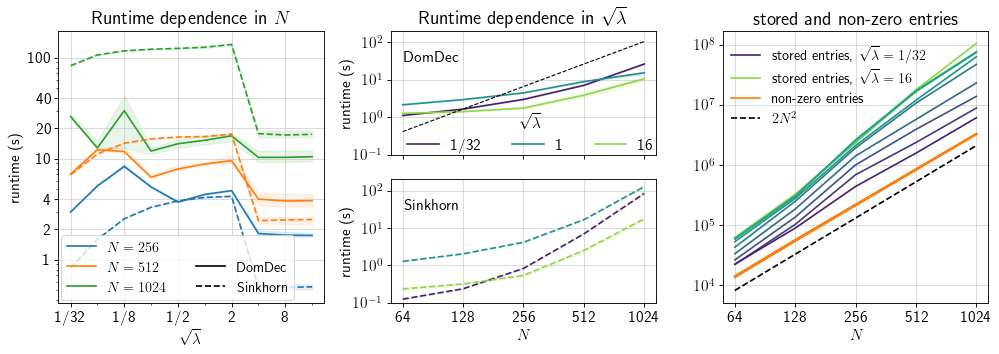

In [13]:
alpha_fill_between = 0.1
# fig, axs = plt.subplots(1,3,figsize = (15, 4.5), dpi = 80)
fig, axs = plt.subplot_mosaic("ABD;ACD",figsize = (15, 4.5), dpi = 80)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

axs = [axs["A"], axs["B"], axs["C"],axs["D"]]

lss = ["-", "--"]
cmap = plt.cm.viridis


methods = ["domdec", "sinkhorn"]
methodlabels = ["DomDec","Sinkhorn"]

# First plot

for j,method in enumerate(methods): 
    for i,N in enumerate([256, 512, 1024]):
        label = f"$N = {N}$" if method == "domdec" else "_nolegend_"
        s = df_median[(df_median.N == N) & (df_median.method == method)].time_total
        q0 = df_q0[(df_q0.N == N) & (df_q0.method == method)].time_total
        q1 = df_q1[(df_q1.N == N) & (df_q1.method == method)].time_total
        axs[0].plot(reaches, s, color = colors[i], ls = lss[j], label = label)
        axs[0].fill_between(reaches, q0, q1, alpha = alpha_fill_between, color = colors[i],
                         label = "_nolegend_")
        
axs[0].plot([],[], label = " ", color = "white")
axs[0].plot([],[], color = "k", ls = "-",label = "DomDec")
axs[0].plot([],[], color = "k", ls = "--",label = "Sinkhorn")
axs[0].legend(ncol = 2, fontsize = 13, loc = (0.01,0.01))


axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xticks(reaches[::2], map(lambda x: str(int(x)) if x >= 1 else f"1/{int(1/x)}", reaches[::2]), minor = False)
axs[0].set_xticks(reaches, [], minor = True)
yticks = [1, 2, 4, 10, 20, 40, 100]
axs[0].set_yticks(yticks, list(map(str, yticks)), minor = False)
axs[0].grid(alpha = 0.5)

axs[0].set_xlabel("$\sqrt{\lambda}$")
axs[0].set_ylabel("runtime (s)")
axs[0].set_title("Runtime dependence in $N$")

# axs[1].sharex(axs[2])

for j,method in enumerate(methods): 
    for i, reach in enumerate([1/32, 1, 16]):
        label = ff(reach)
        s = df_median[(df_median.reach == reach) & (df_median.method == method)].time_total
        q0 = df_q0[(df_q0.reach == reach) & (df_q0.method == method)].time_total
        q1 = df_q1[(df_q1.reach == reach) & (df_q1.method == method)].time_total
        color = cmap((np.log2(reach)+6)/12)
        axs[j+1].plot(Ns, s, color = color, ls = lss[j], label = label)
        axs[j+1].fill_between(Ns, q0, q1, alpha = alpha_fill_between, color = color,
                        label = "_nolegend_")
    axs[j+1].set_xscale("log")
    axs[j+1].set_yscale("log")
    axs[2].set_xlabel("$N$")
    axs[j+1].set_ylabel("runtime (s)", labelpad = -0.4)
    axs[j+1].set_yticks([], minor = True)
    axs[j+1].set_xticks([], minor = True)
    axs[j+1].set_ylim([0.1, 200])
    axs[j+1].text(1.01*64, 30, methodlabels[j])

    axs[j+1].set_xticks(Ns, minor = False)
    axs[j+1].set_xticklabels(Ns)

    axs[1].set_xticklabels([])
    # yticks = [0.1, 0.3, 1, 3, 10, 30, 100]
    # axs[j+1].set_yticks(yticks, list(map(str, yticks)), minor = False)
    axs[j+1].grid(alpha = 0.5)

axs[1].plot(Ns, 1e-4*np.array(Ns)**2, ls = "--", c = "k", lw = 1)
axs[1].legend(title = "$\sqrt{\lambda}$", ncol = 3, loc = (0.04,-0.04), frameon = False)

plt.grid(alpha = 0.5)

axs[1].set_title("Runtime dependence in $\sqrt{\lambda}$")

# Last plot 

Ns = np.array(Ns)
alpha_fill_between = 0.2

ax = axs[-1]
ax.plot(Ns, 2*Ns**2, ls = "--", c = "k", label = "$2N^2$")
# ax.plot(Ns, Ns**2 * np.sqrt(Ns), ls = ":", c = "k", label = r"$N^{2} \sqrt{N}$")
for (i, reach) in enumerate(reaches[::-1]):
    mask = (df_median.method == "domdec") & (df_median.reach == reach)
    n_entries = (df_median[mask].final_muYentries)
    stored_entries = n_entries / df_median[mask].worst_storage_ratio

    color = cmap((np.log2(reach)+6)/12)
    label = "non-zero entries" if i == 0 else ""
    ax.plot(Ns, n_entries, color = "tab:orange", label = label)
    label = r"stored entries, $\sqrt{\lambda}" + f" = {ff(reach)}$" if i in [0, len(reaches)-1] else ""
    ax.plot(Ns, stored_entries, color = color, label = label)


ax.set_xlabel(r"$N$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(Ns, minor = False)
ax.set_xticks([], minor = True)
ax.set_yticks([], minor = True)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticklabels(list(map(lambda s: rf"$\sf{s}$", Ns)))
ax.grid(alpha = 0.5)

ax.set_title("stored and non-zero entries")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc = (0.01, 0.63), fontsize = 13, frameon = False)

plt.subplots_adjust(wspace = 0.25)
plt.savefig(basepath + "runtime-diff-lambda.pdf",
            bbox_inches = "tight")